In [1]:
import os
root = os.path.join('..')
data_root = os.path.join(root, 'data')
dataset_root = os.path.join(root, '..', 'datasets')
fig_root = os.path.join(root, 'figs')

import sys
sys.path.append(root)

In [2]:
from typing import Dict, Optional, Sequence, Tuple

import torch
from torch import Tensor

from utils.fig import Axes, Figure
from utils.theory import calc_adv_threshold, calc_str_adv_threshold

In [3]:
Figure.set_seaborn_theme()
Figure.set_tex()
Figure.set_high_dpi()

In [4]:
lam = .1
for d in (10, 100, 1000):
    print(d, lam, calc_adv_threshold(d, lam))
    print(d, lam, calc_str_adv_threshold(d, lam))

10 0.1 0.145
10 0.1 0.9723300970873786
100 0.1 0.059500000000000004
100 0.1 0.7642857142857142
1000 0.1 0.05095
1000 0.1 0.2693995381062355


In [5]:
def load_individual(weight_name: str, fname: str) -> Tuple[float, float]:
    p = os.path.join(data_root, 'test', weight_name, fname, 'accs')
    accs_batch: Tensor = torch.load(p)
    m = accs_batch.mean().item()
    s = accs_batch.std(0).item()
    return m, s

In [6]:
fnames = [
    'batch_size=1000_d=100_N_demos=1000_N_queries=1000_lam=0.1_eps=0.0_seed=0',
    'batch_size=1000_d=100_N_demos=1000_N_queries=1000_lam=0.1_eps=0.15_seed=0',
    'batch_size=1000_d_rob=10_d_vul=90_d_irr=0_N_demos=1000_N_queries=1000_alpha=1.0_beta=0.1_gamma=0.1_eps=0.0_seed=0',
    'batch_size=1000_d_rob=10_d_vul=90_d_irr=0_N_demos=1000_N_queries=1000_alpha=1.0_beta=0.1_gamma=0.1_eps=0.3_seed=0',
    'dataset_name=MNIST_N_demos=None_eps=0.0_seed=0',
    'dataset_name=MNIST_N_demos=None_eps=0.1_seed=0',
    'dataset_name=FMNIST_N_demos=None_eps=0.0_seed=0',
    'dataset_name=FMNIST_N_demos=None_eps=0.15_seed=0',
    'dataset_name=CIFAR10_N_demos=None_eps=0.0_seed=0',
    'dataset_name=CIFAR10_N_demos=None_eps=0.1_seed=0',
]

for fname in fnames:
    print(fname)
    for weight_name in ('ideal_std', 'ideal_adv'):
        m, s = load_individual(weight_name, fname)
        print(m, s)
    print()


batch_size=1000_d=100_N_demos=1000_N_queries=1000_lam=0.1_eps=0.0_seed=0
1.0 0.0
1.0 0.0

batch_size=1000_d=100_N_demos=1000_N_queries=1000_lam=0.1_eps=0.15_seed=0
0.0 0.0
1.0 0.0

batch_size=1000_d_rob=10_d_vul=90_d_irr=0_N_demos=1000_N_queries=1000_alpha=1.0_beta=0.1_gamma=0.1_eps=0.0_seed=0
1.0 0.0
0.9996861219406128 0.0005510725313797593

batch_size=1000_d_rob=10_d_vul=90_d_irr=0_N_demos=1000_N_queries=1000_alpha=1.0_beta=0.1_gamma=0.1_eps=0.3_seed=0
0.00041400003829039633 0.0006284894770942628
0.9524950385093689 0.006661708932369947

dataset_name=MNIST_N_demos=None_eps=0.0_seed=0
0.9461381435394287 0.042110808193683624
0.9337537884712219 0.06191249564290047

dataset_name=MNIST_N_demos=None_eps=0.1_seed=0
0.04126125946640968 0.038124747574329376
0.7215855717658997 0.11775313317775726

dataset_name=FMNIST_N_demos=None_eps=0.0_seed=0
0.9176555871963501 0.09049804508686066
0.8972889184951782 0.10352461785078049

dataset_name=FMNIST_N_demos=None_eps=0.15_seed=0
0.20241111516952515 0.15

In [7]:
def load(fname_format: str, variables: Sequence[float]) -> Tuple[Dict[str, Tensor], Dict[str, Tensor]]:
    mean_along_batch = {}
    std_along_batch = {}

    for weight_name in ('ideal_std', 'ideal_adv'):
        mean_along_batch[weight_name] = []
        std_along_batch[weight_name] = []

        for v in variables:
            fname = fname_format.format(v)

            m, s = load_individual(weight_name, fname)

            mean_along_batch[weight_name].append(m)
            std_along_batch[weight_name].append(s)
    
        mean_along_batch[weight_name] = torch.tensor(mean_along_batch[weight_name])
        std_along_batch[weight_name] = torch.tensor(std_along_batch[weight_name])

    return mean_along_batch, std_along_batch

In [8]:
def embed(
    ax: Axes, 
    fname_format: str, 
    variables: Sequence[float], 
    xlabel: str, 
    log: bool = False, 
    linestyle: Optional[str] = None, 
    label1: str = 'Std', 
    label2: str = 'Adv',
) -> None:
    mean, std = load(fname_format, variables)
    ax.line_with_band(variables, mean['ideal_std'], std['ideal_std'], marker='o', label=label1, linestyle=linestyle)
    ax.line_with_band(variables, mean['ideal_adv'], std['ideal_adv'], marker='X', label=label2, linestyle=linestyle)
    ax.set_xlabel(xlabel)
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    if log:
        ax.set_xlogscale()

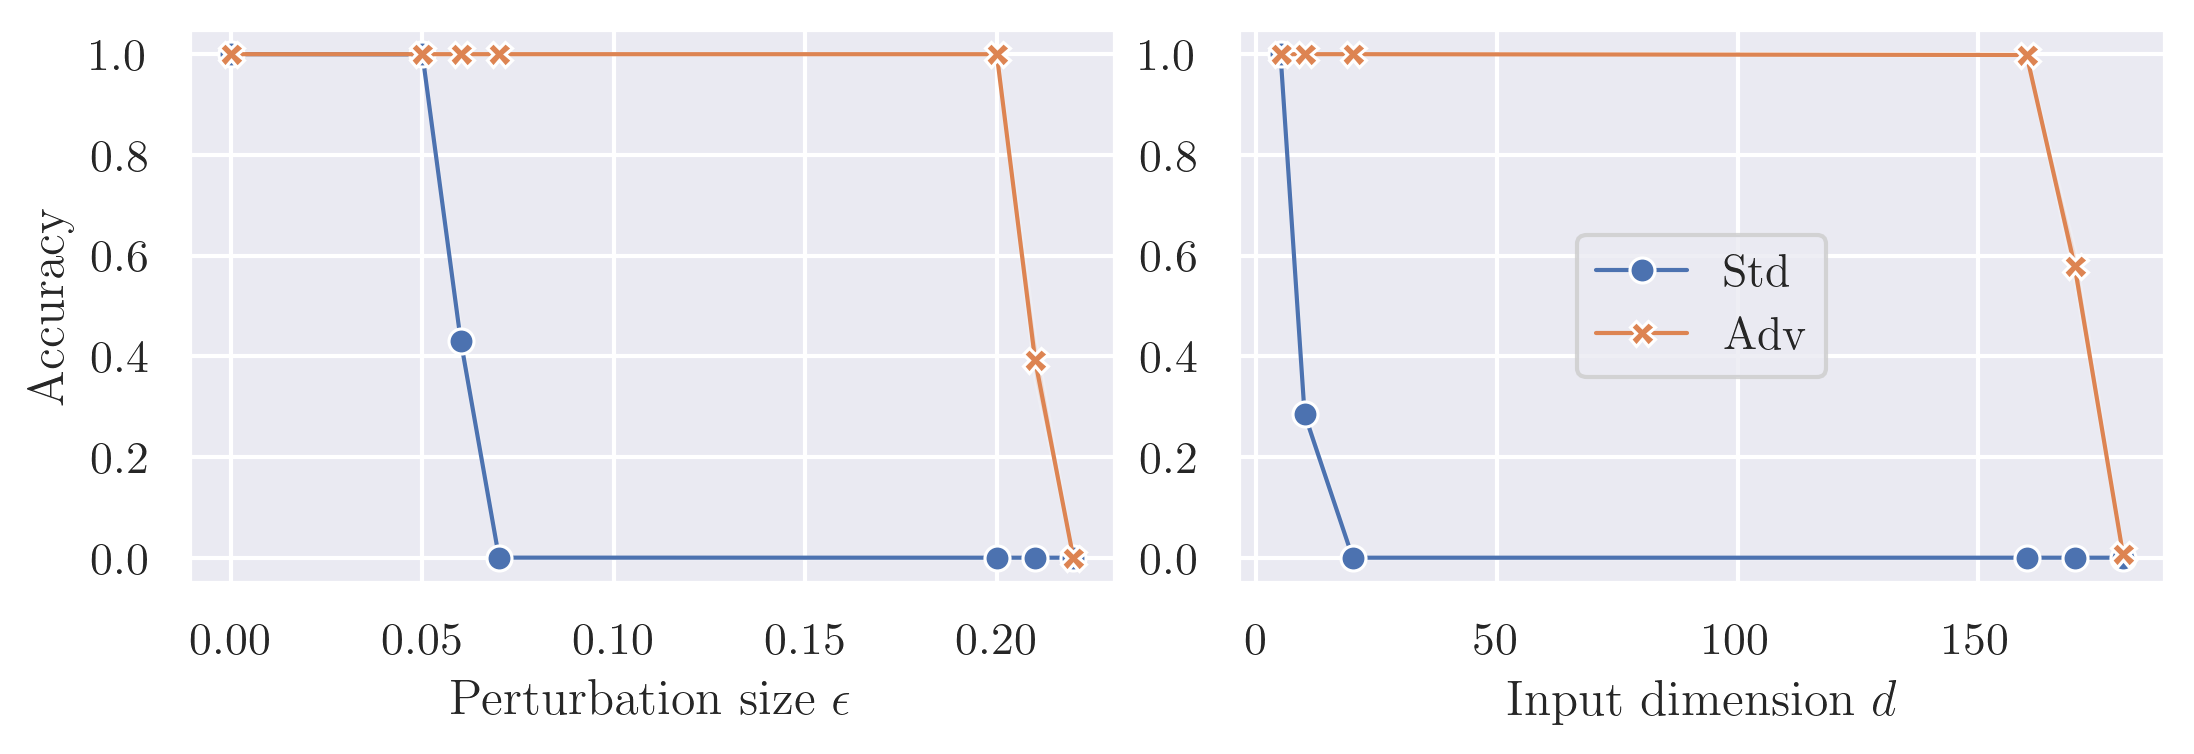

In [9]:
f = Figure(1, 2, (7.2, 2.4))

fname_format = 'batch_size=1000_d=100_N_demos=1000_N_queries=1000_lam=0.1_eps={}_seed=0'
x = [0., .05, .06, .07, .2, .21, .22]
xlabel = r'Perturbation size $\epsilon$'
embed(f.axes[0][0], fname_format, x, xlabel)

fname_format = 'batch_size=1000_d={}_N_demos=1000_N_queries=1000_lam=0.1_eps=0.15_seed=0'
x = [5, 10, 20, 160, 170, 180]
xlabel = r'Input dimension $d$'
embed(f.axes[0][1], fname_format, x, xlabel)

f.axes[0][0].set_ylabel('Accuracy')
f.axes[0][1].legend()

f.save(fig_root, 'train.pdf')
f.show()

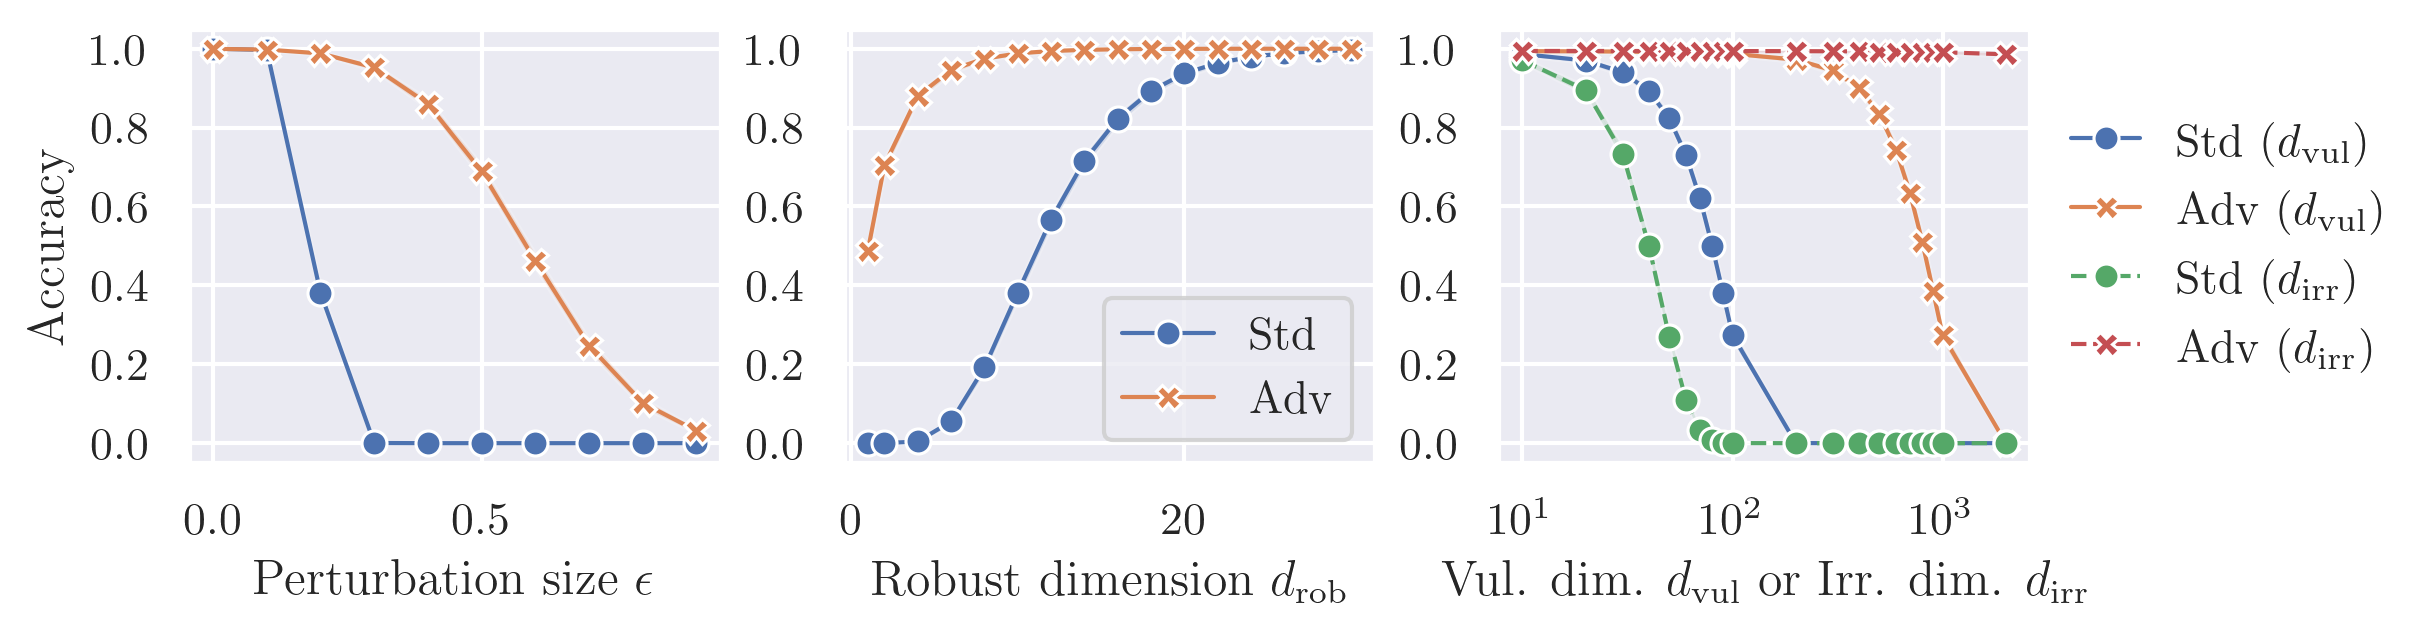

In [10]:
f = Figure(1, 3, (8, 2))

fname_format = 'batch_size=1000_d_rob=10_d_vul=90_d_irr=0_N_demos=1000_N_queries=1000_alpha=1.0_beta=0.1_gamma=0.1_eps={}_seed=0'
x = [i / 10 for i in range(10)]
xlabel = r'Perturbation size $\epsilon$'
embed(f.axes[0][0], fname_format, x, xlabel)

fname_format = 'batch_size=1000_d_rob={}_d_vul=90_d_irr=0_N_demos=1000_N_queries=1000_alpha=1.0_beta=0.1_gamma=0.1_eps=0.2_seed=0'
x = [1] + list(range(2, 32, 2))
xlabel = r'Robust dimension $d_\mathrm{rob}$'
embed(f.axes[0][1], fname_format, x, xlabel)

x = list(range(10, 100, 10)) + list(range(100, 1000, 100)) + [1000, 2000]
xlabel = r'Vul. dim. $d_\mathrm{vul}$ or Irr. dim. $d_\mathrm{irr}$'

fname_format = 'batch_size=1000_d_rob=10_d_vul={}_d_irr=0_N_demos=1000_N_queries=1000_alpha=1.0_beta=0.1_gamma=0.1_eps=0.2_seed=0'
embed(f.axes[0][2], fname_format, x, xlabel, True, label1=r'Std ($d_\mathrm{vul}$)', label2=r'Adv ($d_\mathrm{vul}$)')
fname_format = 'batch_size=1000_d_rob=10_d_vul=0_d_irr={}_N_demos=1000_N_queries=1000_alpha=1.0_beta=0.1_gamma=0.1_eps=0.2_seed=0'
embed(f.axes[0][2], fname_format, x, xlabel, True, '--', label1=r'Std ($d_\mathrm{irr}$)', label2=r'Adv ($d_\mathrm{irr}$)')

f.axes[0][0].set_ylabel('Accuracy')
f.axes[0][1].legend()

f.axes[0][2].set_legend_right(frameon=False, handlelength=1.5)

f.save(fig_root, 'normal.pdf')
f.show()

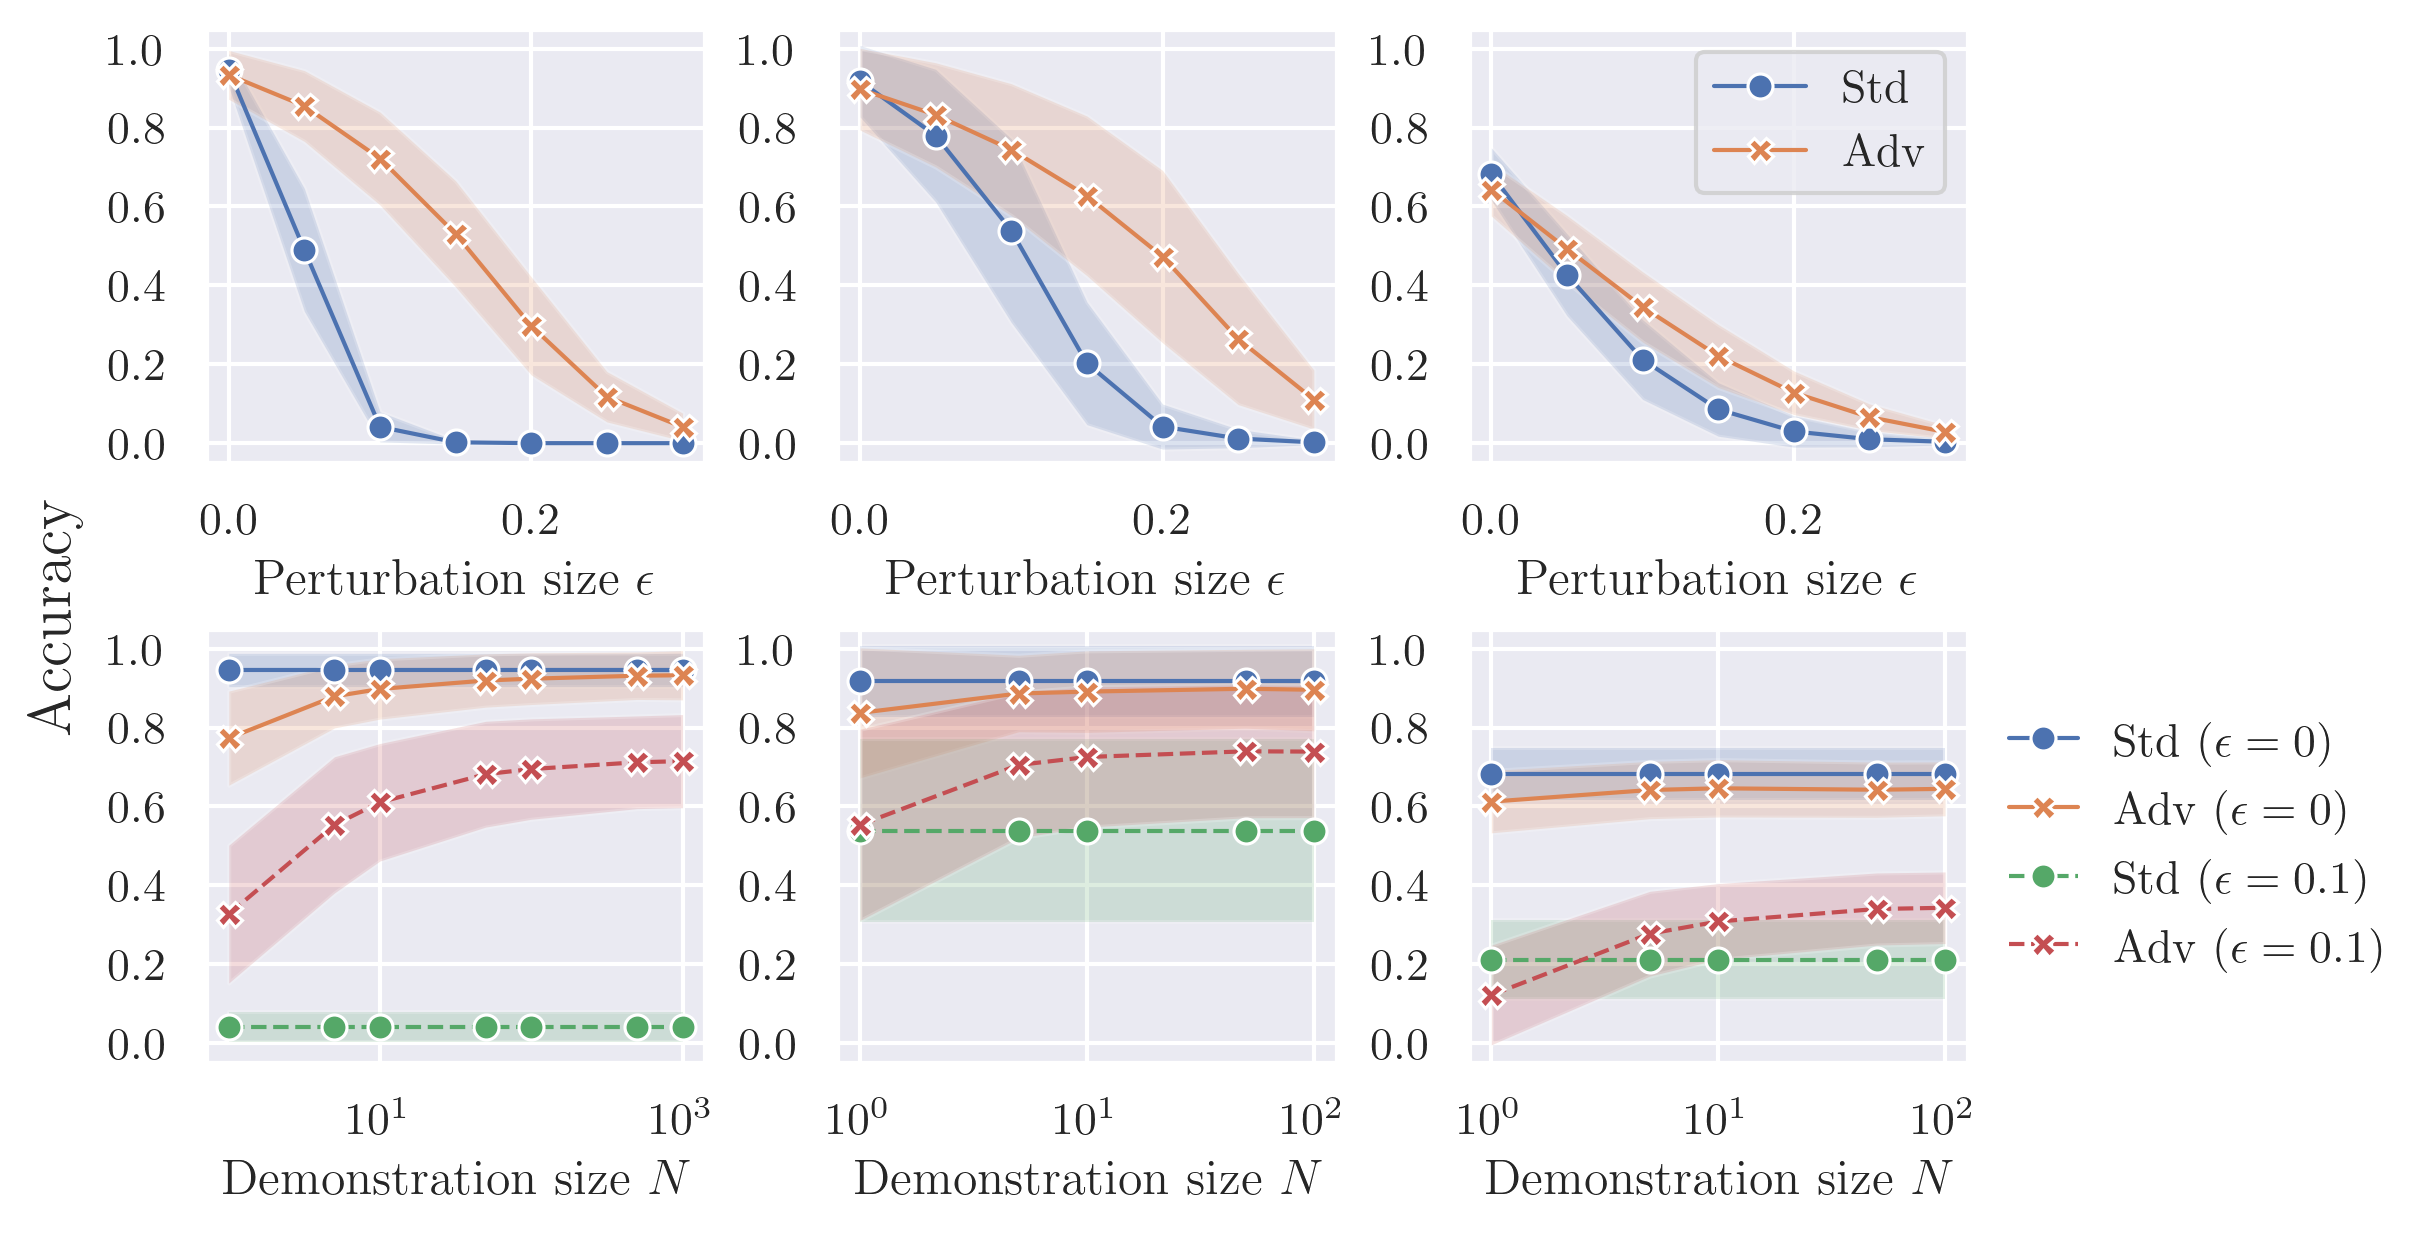

In [11]:
f = Figure(2, 3, (8, 4))

x = [i/100 for i in range(0, 35, 5)]
xlabel = r'Perturbation size $\epsilon$'

fname_format = 'dataset_name=MNIST_N_demos=None_eps={}_seed=0'
embed(f.axes[0][0], fname_format, x, xlabel)

fname_format = 'dataset_name=FMNIST_N_demos=None_eps={}_seed=0'
embed(f.axes[0][1], fname_format, x, xlabel)

fname_format = 'dataset_name=CIFAR10_N_demos=None_eps={}_seed=0'
embed(f.axes[0][2], fname_format, x, xlabel)

xlabel = r'Demonstration size $N$'

x = [1, 5, 10, 50, 100, 500, 1000]
fname_format = 'dataset_name=MNIST_N_demos={}_eps=0.0_seed=0'
embed(f.axes[1][0], fname_format, x, xlabel, True)

fname_format = 'dataset_name=MNIST_N_demos={}_eps=0.1_seed=0'
embed(f.axes[1][0], fname_format, x, xlabel, True, '--')

x = [1, 5, 10, 50, 100]
fname_format = 'dataset_name=FMNIST_N_demos={}_eps=0.0_seed=0'
embed(f.axes[1][1], fname_format, x, xlabel, True)

fname_format = 'dataset_name=FMNIST_N_demos={}_eps=0.1_seed=0'
embed(f.axes[1][1], fname_format, x, xlabel, True, '--')

fname_format = 'dataset_name=CIFAR10_N_demos={}_eps=0.0_seed=0'
embed(f.axes[1][2], fname_format, x, xlabel, True, label1=r'Std ($\epsilon=0$)', label2=r'Adv ($\epsilon=0$)')

fname_format = 'dataset_name=CIFAR10_N_demos={}_eps=0.1_seed=0'
embed(f.axes[1][2], fname_format, x, xlabel, True, '--', label1=r'Std ($\epsilon=0.1$)', label2=r'Adv ($\epsilon=0.1$)')

f.set_supylabel('Accuracy')

f.axes[0][2].legend()
f.axes[1][2].legend()

f.axes[1][2].set_legend_right(frameon=False, handlelength=1.5)

f.save(fig_root, 'real.pdf')
f.show()